# SCM.293 - Session 4 - Location-Allocation MIPs and OSMnx
## Load Packages

In [1]:
import sys
import numpy as np
import math
import random

import pandas as pd

from scipy.spatial import distance
from haversine import haversine

import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt

from tqdm import tqdm

import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
print(sys.version)

3.6.15 | packaged by conda-forge | (default, Dec  3 2021, 18:49:43) 
[GCC Clang 11.1.0]


## Define Classes

In [3]:
class customer:
    """
    A class used to represent a single customer node
    
    Parameters
    ----------
    x : float
        the x-coordinate of the customer location
    y : float
        the y-coordinate of the customer location
    cust_ID : str
        a (preferrably unique) identifier of the customer
    q : float
        the amount of demand (i.e., drop size) of the customer
        default value: 1

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the customer
    type : str
        an identifier of the type of node the class represents (here: customer node)
    
    """
    
    def __init__(self,
                x,             
                y,
                cust_ID,         
                q = 1):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.cust_ID = str(cust_ID)
        self.type = 'customer'
        self.q = float(q)
        
        self.closestNetworkNode = None

In [4]:
class depot:
    """
    A class used to represent a single depot node
    
    Parameters
    ----------
    x : float
        the x-coordinate of the customer location
    y : float
        the y-coordinate of the customer location
    color : str
        color with which to plot the routes departing from the depot when visualizing the results 
    dep_ID : str
        a (preferrably unique) identifier of the depot

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the depot
    type : str
        an identifier of the type of node the class represents (here: depot node)
    s : float
        the time required to serve the depot
        needed for technical reasons
        set to zero
    
    """
    
    def __init__(self,
                x,
                y,
                dep_ID,
                F):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.dep_ID = str(dep_ID)
        self.F = float(F)
        self.type = 'depot'
        
        self.closestNetworkNode = None

## Define Functions

Determine the node on a network that is closest to an arbitrary point

In [5]:
def closestNode(nodes, v, invDict):
    """
    nodes: array-like of node locations (tuples)
    v: point to test
    invDict: dictionary of node location to node ID
    ------
    Note to students: replacing haversine distance with Euclidean 
        distance and scipy.distance.cdist may be slightly more efficient.
        Distortion errors from using Euclidean probably acceptable here.
    """
    
    # Function that returns the location of the node that is closest to the point tested
    closest = min(nodes, key=lambda p: haversine(
            [v[0],v[1]],
            [p[0],p[1]])
            )

    # based on that location, return the ID of the closest node
    return invDict[closest]

Project arbitrary demand data (points of demand) to the closest nodes of an underlying road network

In [6]:
def projectDataOSM(point_data, graph, Save=False, filename=None):
    
    # create dictionary of node locations : node ID
    network_nodes = {}
    for n in graph.nodes.keys():
        network_nodes[(graph.nodes[n]['y'],graph.nodes[n]['x'])] = n
        
    # snap each point to nearest node (intersection) on road network
    
    nodes = []
    for index,row in tqdm(point_data.iterrows()):
        nodes.append(closestNode(network_nodes.keys(), (row.lat,row.lng), network_nodes))

    point_data['closest_nw_node'] = nodes
    
    # Save to file
    
    if Save==True:
        if filename == None:
            print('File name not specified.')
        else:
            point_data.to_csv(filename)

Function to obtain random unique color for every depot

In [7]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

Map arbitrary demand data (points of demand) and (optional) arbitrary route data (trips on the network) to the underlying OSM road network

In [8]:
def mapDataOSM(demand_data, depot_data, inactive_depot_data=pd.DataFrame(), snap_to_grid=True, route_data=None, Plot=True):
       
    # get bounding box of customer locations
    
    ymax = max(demand_data.lat.append(demand_data.lat))
    print(ymax,'y max')
    ymin = min(demand_data.lat.append(demand_data.lat))
    print(ymin,'y min')
    xmax = max(demand_data.lng.append(demand_data.lng))
    print(xmax,'x max')
    xmin = min(demand_data.lng.append(demand_data.lng))
    print(xmin,'x min')
    
    # query OSMnx graph around extents of customer nodes
    
    g = ox.graph_from_bbox(
        ymax, ymin, xmax, xmin,
        network_type = 'drive',
        truncate_by_edge = True,
        clean_periphery = True
    )
       
    # snap each point to nearest node (intersection) on road network graph
    if snap_to_grid==True:
        projectDataOSM(demand_data, g)
        projectDataOSM(depot_data, g)
    else:
        print('Assuming nodes already projected on OSM graph.')

    
    # Plot on network
    
    if Plot==True:
        
        cmap = get_cmap(len(depot_data))
        
        if route_data != None:
            
            print('Plotting arcs...')
            
            myroutes = []
            myroutecolors=[]
            depid=0
            for d in route_data:
                myroutes = myroutes + route_data[d]
                myroutecolors = myroutecolors + [cmap(depid) for i in range(len(route_data[d]))]
                depid = depid+1      
              
                           
            fig, ax = ox.plot_graph_routes(g, 
                                           myroutes, #route_data, 
                                           figsize=(25,25),
                                           node_size=0, 
                                           node_alpha=1,
                                           edge_linewidth=0.5,
                                           edge_alpha = 0.5,
                                           route_alpha = 0.5,
                                           route_colors = myroutecolors,
                                           route_linewidths = 1,
                                           orig_dest_size=0,
                                           dpi=300, 
                                           show=False, close=False)
            
        else:

            fig, ax = ox.plot_graph(g, figsize=(20,20), show=False, close=False, edge_alpha = 0.25, node_alpha = 0)
            
        
        print('Plotting customer nodes...')
        
        for date in demand_data.OrderDate.unique():
            
            ax.scatter(demand_data[demand_data.OrderDate==date].lng,
                       demand_data[demand_data.OrderDate==date].lat,
                       alpha=0.5,
                       s=20*data[demand_data.OrderDate==date].OrderSize)
        
        
        print('Plotting depot nodes...')
        
        for index, row in depot_data.iterrows():
            ax.scatter(
                row['lng'], 
                row['lat'], 
                color=cmap(index),
                marker='s',
                s=80
            )
        
        
        if not inactive_depot_data.empty:
            ax.scatter(inactive_depot_data.lng,
               inactive_depot_data.lat,
               alpha=1.0,
               color='gray',
               marker='s',
               s=80)

        plt.show()
    
    return g, fig, ax

Calculate a distance between two nodes

In [9]:
def calc_dist(orig,dest,mode='Euclidian'):
    """
    Calculates a Euclidian distance

    Parameters
    ----------
    orig : customer or depot object
        origin node
    dest : customer or depot object
        destination node
    mode : string
        type of distance metric to use

    Returns
    -------
    dist : float
        Euclidian distance between origin and destination node
    """
    if mode == 'Euclidian':
        
        dist =  math.sqrt((orig[0]-dest[0])**2+(orig[1]-dest[1])**2) 
        
    elif mode == 'Haversine':
        
        dist = haversine([orig[0],orig[1]],[dest[0],dest[1]])
        
    else:
        
        dist = None
        print("Undefined distance metric.")
    
    return dist

Compute a pairwise distance matrix for a list of nodes

In [10]:
def d_matrix(nodes,g=None,mode='Euclidian',returnPaths=False):
    """
    Calculates a distance matrix

    Parameters
    ----------
    nodes : dict of customer or depot object
        all nodes (custoemrs, depots) in the network
    mode : str
        type of distance to use
        default value: Euclidian

    Returns
    -------
    dist_mat : dict 
        origin-destination matrix of distances
    """
    
    if mode == 'Euclidian' or mode == 'Haversine':
        dist_mat = dict(
            [((i,j),calc_dist(nodes[i].loc,nodes[j].loc,mode)) 
             for i in tqdm(nodes) for j in nodes]
            )
        path_mat = None
    elif mode == 'OSM':
        if g == None:
            dist_mat = {}
            print("Network information missing.")
        else:
            dist_mat = dict(
                [((i,j),nx.shortest_path_length(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode, weight='length')) 
                 for i in tqdm(nodes) for j in nodes]
            )
            if returnPaths == True:
                path_mat = dict(
                    [((i,j),nx.shortest_path(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode)) 
                     for i in tqdm(nodes) for j in nodes]
                )
            else:
                path_mat = None
            
    else: 
        dist_mat = {}
        path_mat = None
        print("Undefined distance metric.")
        
    return dist_mat, path_mat

## Initiate Problem
### Load and Filter Data

In [11]:
# load demand data 
demand = pd.read_csv('SCM293_inclass_locationproblems_5days_NYC.csv')
demand.head()

,CustomerID,lat,lng,delivery_locality,delivery_zipcode,OrderSize,OrderDate
0,fa5210e3-f9e6-46b6-b3ec-b8aa868070d9,40.762750,-73.980883,manhattan,10019,7,2/25/14
1,11da9213-a03d-49e7-8609-603c1b83d743,40.754552,-73.990854,manhattan,10018,7,2/25/14
2,d527727e-b7ca-4fbe-8f43-779d32cf335b,40.720388,-74.002408,manhattan,10013,7,2/25/14
3,e04ed4ca-75f9-40cf-90c7-a53d442b5c1b,40.726019,-73.995445,manhattan,10012,2,2/25/14
4,bdafeaab-4b70-4ff3-a294-3d562944cae7,40.759499,-73.982245,manhattan,10020,1,2/24/14


In [12]:
# filter for a single day
data = demand[demand.OrderDate=='2/26/14']
print(str(len(data))+' customer orders on Feb 26, 2014')

# remove duplicates (let's assume each customer only places one order for now)
data.drop_duplicates(subset ="CustomerID", 
                     keep = 'first', inplace = True)
print(str(len(data))+' unique customers on Feb 26, 2014')

data.head()

336 customer orders on Feb 26, 2014
227 unique customers on Feb 26, 2014


/Users/mwinkenb/opt/anaconda3/envs/scm293/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,CustomerID,lat,lng,delivery_locality,delivery_zipcode,OrderSize,OrderDate
324,bdc27b12-7e74-4413-b38a-384ca95ed3e4,40.754767,-73.984915,manhattan,10036,3,2/26/14
520,e20a043a-1a2d-4cb4-872a-06e42f8aefea,40.724534,-73.999571,manhattan,10012,1,2/26/14
570,8540a944-25a9-4b89-acf5-cba29eac5e89,40.796494,-73.930039,manhattan,10035,8,2/26/14
571,5a3a3673-506e-4feb-96fa-0e139a4dd19e,40.749795,-73.971162,manhattan,10017,6,2/26/14
649,8eda5be4-e4fd-4091-8c85-4150dfd30091,40.723462,-74.006830,manhattan,10013,3,2/26/14


In [13]:
# load depot data 
dep_locs = pd.read_csv('SCM293_inclass_locationproblems_depots_NYC.csv')
dep_locs

,DepotID,lat,lng
0,dep001,40.715974,-73.986576
1,dep002,40.746109,-73.950401
2,dep003,40.755563,-74.003533
3,dep004,40.733659,-73.980893
4,dep005,40.769913,-73.986474
5,dep006,40.795647,-73.974065
6,dep007,40.788268,-73.954585
7,dep008,40.803107,-73.952478
8,dep009,40.760458,-73.981776
9,dep010,40.720661,-74.003639


### Project Customer and Depot Nodes on OSM Road Network and Plot

Without Route Information

40.8625608 y max
40.7028885 y min
-73.93003859999999 x max
-74.0155582 x min


227it [00:04, 54.63it/s]
/Users/mwinkenb/opt/anaconda3/envs/scm293/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
10it [00:00, 53.37it/s]


Plotting customer nodes...
Plotting depot nodes...


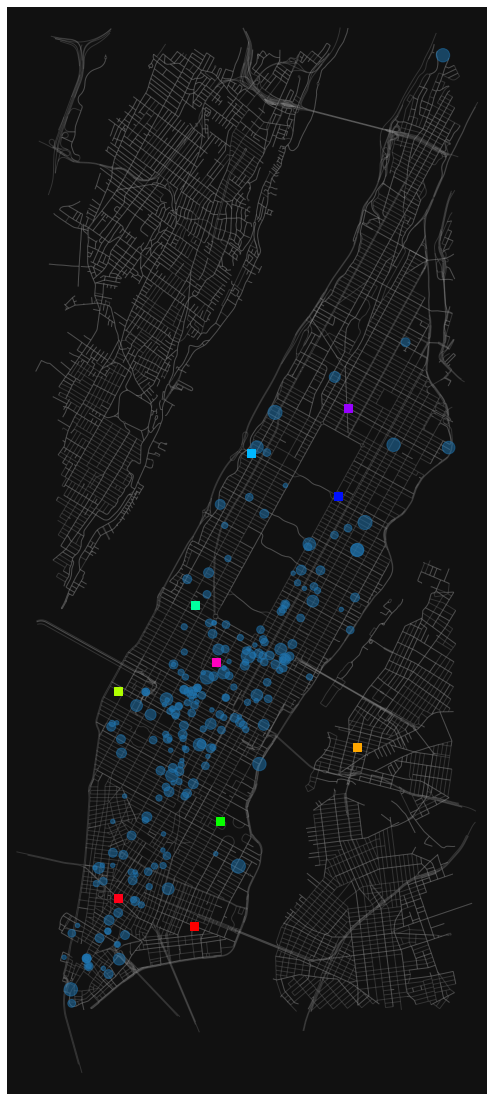

In [14]:
myg, fig, ax = mapDataOSM(data,dep_locs)

### Create Customer and Depot Objects

__Customers__

In [15]:
customers = dict([
    (data.CustomerID.iloc[i],
     customer(data.lat.iloc[i],
              data.lng.iloc[i],
              data.CustomerID.iloc[i],
              data.OrderSize.iloc[i])) for i in range(len(data))
])

Assign closest network nodes

In [16]:
for i in customers:
    customers[i].closestNetworkNode = int(data[data.CustomerID==i].closest_nw_node)

__Depots__

In [17]:
depots = dict([
    (dep_locs.loc[i].DepotID,
     depot(x=dep_locs.lat.iloc[i],
           y=dep_locs.lng.iloc[i],
           dep_ID=dep_locs.DepotID.iloc[i],
           F=0)) for i in range(len(dep_locs))
])

Assign closest network nodes

In [18]:
for i in depots:
    depots[i].closestNetworkNode = int(dep_locs[dep_locs.DepotID==i].closest_nw_node)

__Joint Set of Nodes__

In [19]:
mynodes = {**depots, **customers}

_____

### Calculate Distance Matrices

Euclidian

In [20]:
distances_Euc = d_matrix(mynodes,myg,mode='Haversine')

100%|██████████| 237/237 [00:00<00:00, 1781.01it/s]


Real OSM road network

In [21]:
distances_OSM, paths_OSM = d_matrix(mynodes,myg,mode='OSM',returnPaths=True)

100%|██████████| 237/237 [00:46<00:00,  5.06it/s]


## Set Up MIP Model: Simple Transportation Problem

Formulation discussed in class:

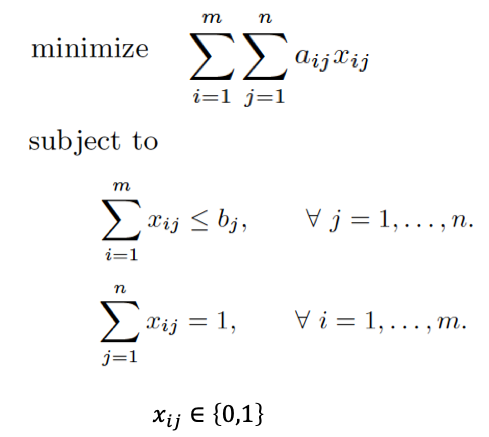

__Note:__ We're implementing a slightly different capacity constraint here.

### Set Parameters

Set depot capacity

In [22]:
depot_capacity = 100.0

### Define Model Formulation
Create Gurobi model

In [23]:
m = gp.Model("LAP")

Academic license - for non-commercial use only - expires 2023-03-24
Using license file /Users/mwinkenb/gurobi.lic


Create decision variables

In [24]:
# Create variables
X = dict(
    [((d,i), m.addVar(vtype=GRB.BINARY, name="x_%s_%s" %(d,i))) 
     for d in depots for i in customers]
)

Set objective

In [25]:
# Set objective
m.setObjective(
    quicksum([(distances_OSM[(d,i)]+distances_OSM[(i,d)])*X[(d,i)] 
              for d in depots for i in customers]), 
               GRB.MINIMIZE)

Add constraints

- all customers allocated
- depot capacities not exceeded

In [26]:
# Add constraints:
full_allocation = dict(
    [(i,m.addConstr(quicksum([X[(d,i)] for d in depots]) == 1, "all_alloc_%s" %i)) 
     for i in customers]
)
depot_capa = dict(
    [(i,m.addConstr(quicksum([X[(d,i)]*customers[i].q for i in customers]) <= depot_capacity, "capa_%s" %d)) 
     for d in depots]
)

### Solve model

In [27]:
m.update()
m.reset()

# Set model parameters
m.Params.timelimit = 300.0
m.Params.MIPGap = 0.0001

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Parameter MIPGap unchanged
   Value: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 237 rows, 2270 columns and 4540 nonzeros
Model fingerprint: 0x1ec20573
Variable types: 0 continuous, 2270 integer (2270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [3e+02, 4e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 2277928.8250
Presolve time: 0.01s
Presolved: 237 rows, 2270 columns, 4540 nonzeros
Variable types: 0 continuous, 2270 integer (2270 binary)

Root relaxation: objective 6.807905e+05, 260 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntI

### Plot Results

Obtain allocation paths

In [28]:
#mypaths = [paths_OSM[i] for i in X if round(X[i].x)==1]
mypaths = dict([(d,[paths_OSM[(d,i)] for i in customers if round(X[(d,i)].x)==1]) for d in depots])

Plot on OSM road network graph, together with customers and depots

40.8625608 y max
40.7028885 y min
-73.93003859999999 x max
-74.0155582 x min
Assuming nodes already projected on OSM graph.
Plotting arcs...
Plotting customer nodes...
Plotting depot nodes...


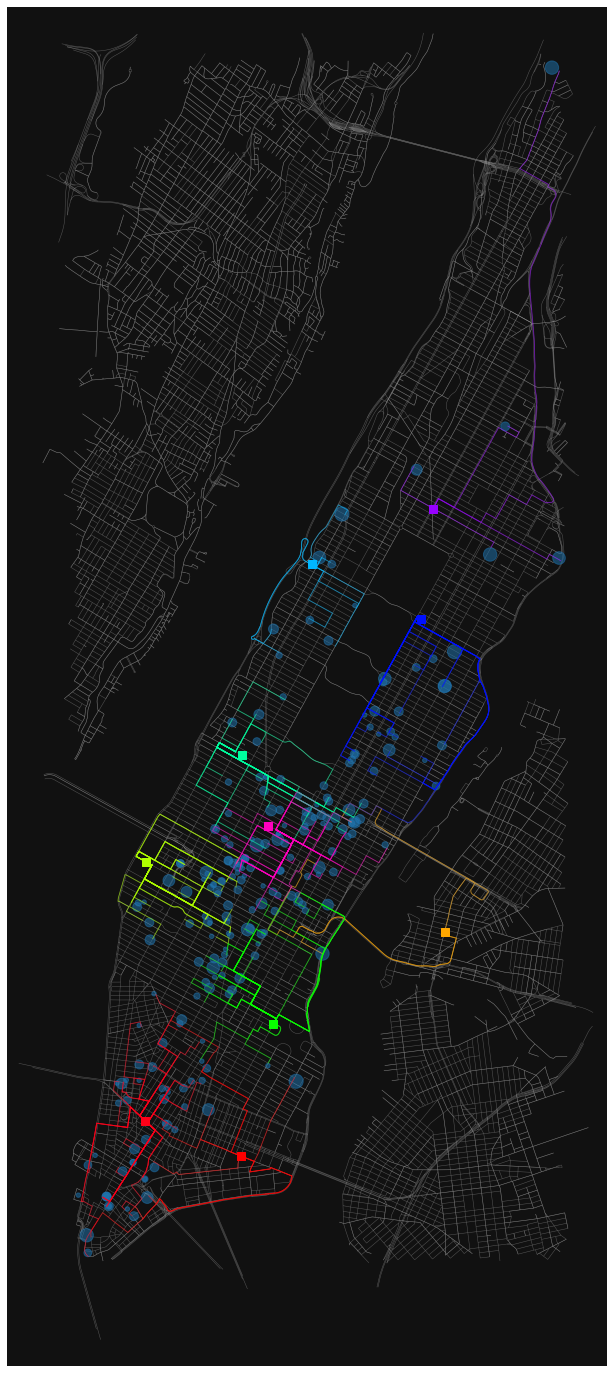

In [29]:
myg, fig, ax = mapDataOSM(data,dep_locs,snap_to_grid=False,route_data=mypaths)

## Extend MIP Model: Facility Location Problem

Formulation discussed in class:

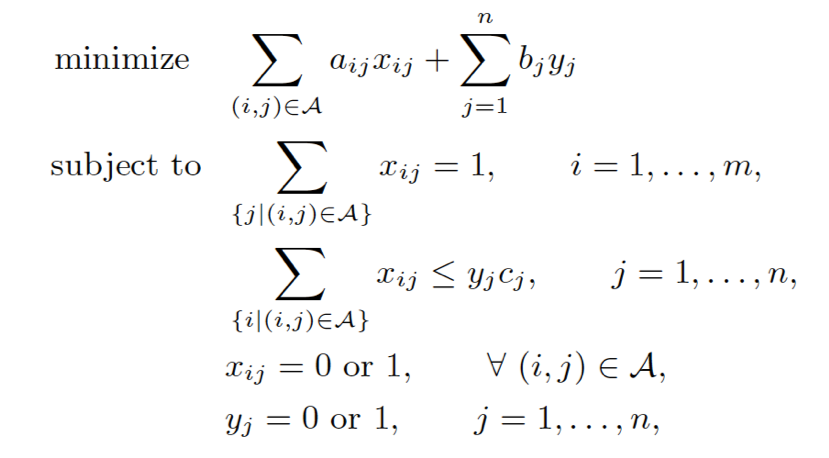

__Note:__ We're implementing a slightly different capacity constraint here.

### Set Parameters

Depot fixed cost

In [30]:
dep_F = 15000.0

# Update fixed cost attribute of all depots (currently zero)
for d in depots:
    depots[d].F = dep_F

Depot capacity

In [31]:
depot_capacity = 1000000.0

### Remove Previously Defined Decision Variables and Constraints

In [32]:
m.remove(m.getVars()[0])
m.remove(m.getConstrs()[0])

### Add Decision Variables

As before:

In [33]:
# Create variables
X = dict(
    [((d,i), m.addVar(vtype=GRB.BINARY, name="x_%s_%s" %(d,i))) 
     for d in depots for i in customers]
)

New:

In [34]:
# Add variables
Y = dict(
    [(d, m.addVar(vtype=GRB.BINARY, name="x__%s" %d)) 
     for d in depots]
)

# Update model
m.update()

### Extend Objective Function

In [35]:
# Set objective
m.setObjective(
    quicksum([(distances_OSM[(d,i)]+distances_OSM[(i,d)])*X[(d,i)] 
              for d in depots for i in customers])
    +quicksum([depots[d].F*Y[d] 
              for d in depots]), 
               GRB.MINIMIZE)

### Add Constraints

As before:

In [36]:
# Add constraints:
full_allocation = dict(
    [(i,m.addConstr(quicksum([X[(d,i)] for d in depots]) == 1, "all_alloc_%s" %i)) 
     for i in customers]
)

New:

In [37]:
# Add constraints:
active_dep_capa = dict(
    [(i,m.addConstr(quicksum([X[(d,i)]*customers[i].q for i in customers]) <= depot_capacity*Y[d] , "act_dep_capa_%s" %d)) 
     for d in depots]
)

# Update model
m.update()

### Solve Model

In [38]:
m.update()
m.reset()

# Set model parameters
m.Params.timelimit = 300.0
m.Params.MIPGap = 0.0001

# Optimize model
m.optimize()

Discarded solution information
Parameter timelimit unchanged
   Value: 300.0  Min: 0.0  Max: inf  Default: inf
Parameter MIPGap unchanged
   Value: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 473 rows, 4549 columns and 9079 nonzeros
Model fingerprint: 0x77d8e39e
Variable types: 0 continuous, 4549 integer (4549 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [3e+02, 4e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 2332125.6230
Presolve removed 236 rows and 2269 columns
Presolve time: 0.01s
Presolved: 237 rows, 2280 columns, 4550 nonzeros
Variable types: 0 continuous, 2280 integer (2280 binary)

Root relaxation: objective 6.226318e+05, 236 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

In [39]:
#mypaths_new = [paths_OSM[i] for i in X if round(X[i].x)==1]
mypaths_new = dict([(d,[paths_OSM[(d,i)] for i in customers if round(X[(d,i)].x)==1]) for d in depots])

In [40]:
dep_locs_active_list = [i for i in Y if round(Y[i].x)==1]
dep_locs_active = dep_locs[dep_locs['DepotID'].isin(dep_locs_active_list)]
print(str(len(dep_locs_active_list))+' out of '+str(len(dep_locs))+' depots activated')
dep_locs_active

6 out of 10 depots activated


,DepotID,lat,lng,closest_nw_node
2,dep003,40.755563,-74.003533,42430629
3,dep004,40.733659,-73.980893,42437289
5,dep006,40.795647,-73.974065,42431099
6,dep007,40.788268,-73.954585,42443264
8,dep009,40.760458,-73.981776,42430358
9,dep010,40.720661,-74.003639,42440825


In [41]:
dep_locs_inactive_list = [i for i in Y if round(Y[i].x)==0]
dep_locs_inactive = dep_locs[dep_locs['DepotID'].isin(dep_locs_inactive_list)]
print(str(len(dep_locs_inactive_list))+' out of '+str(len(dep_locs))+' depots NOT activated')
dep_locs_inactive

4 out of 10 depots NOT activated


,DepotID,lat,lng,closest_nw_node
0,dep001,40.715974,-73.986576,42440408
1,dep002,40.746109,-73.950401,42843270
4,dep005,40.769913,-73.986474,42440935
7,dep008,40.803107,-73.952478,2141026506


40.8625608 y max
40.7028885 y min
-73.93003859999999 x max
-74.0155582 x min
Assuming nodes already projected on OSM graph.
Plotting arcs...
Plotting customer nodes...
Plotting depot nodes...


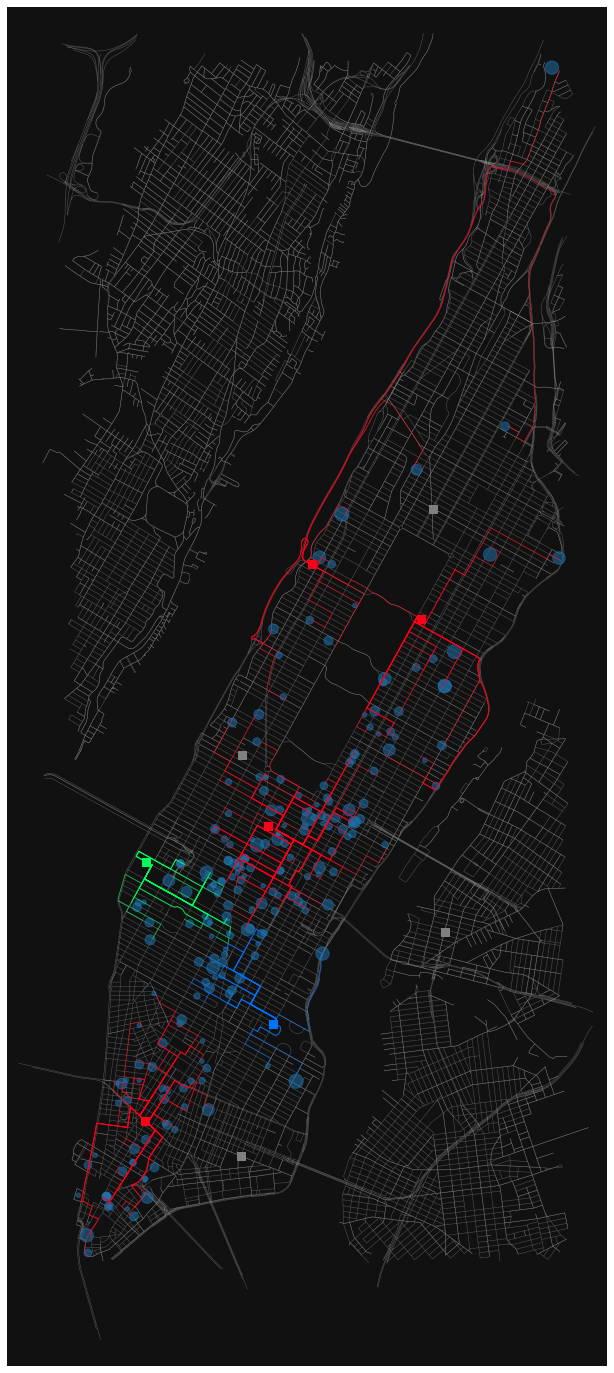

In [42]:
myg, fig, ax = mapDataOSM(data,dep_locs_active,inactive_depot_data=dep_locs_inactive,snap_to_grid=False,route_data=mypaths_new)